# bagged_scikit_neuralnetwork

In [1]:
from __future__ import division
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sknn.mlp                 import Classifier, Layer

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [23]:
SEED   = 97
scale  = True 
minmax = False
norm   = False
nointercept = True
engineering = True

N_CLASSES  = 2
max_epochs = 100

submission_filename = "../submissions/submission_bagged_scikit_nn.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [31]:
"""
["Bagging Predictors" Department of Statistics UC Berkeley 1994; Leo Breiman]
"""

from sklearn.base import BaseEstimator, ClassifierMixin, clone


class BaggedScikitClassifier(BaseEstimator, ClassifierMixin):
    """
    Runs a scikit-learn base estimator 'n_estimators' times, fitting with
    the X_train indices drawn from a random sample of size X_train.shape[0] 
    with replacement
    
    sklearn.ensemble.BaggingClassifier is more convenient and has more tunable
    features but it requires the base estimator to have a 'fit' method with a
    'sample_weight' parameter and many estimators do not 
    (as of sklearn.__version__ == '0.17').
    
    
    Usage
    -----
    clf = BaggedScikitClassifier(base_estimator, n_estimators)
    
        base_estimator is an instance of a scikit-learn object
        n_estimators   is the number of bagged replicas to use
        
    clf.fit(X_train, y_train)
    
        a no-op; merely stores X_train and y_train for use in the
        predict and predict_proba methods
        
    clf.predict(X_test)
    
        the value returned is the majority vote of each of the
        fitted base_estimators' class predictions
        
    clf.predict_proba(X_test)
    
        the value returned is the average of each of the
        fitted base_estimators' probabilities
    """
    def __init__(self, base_estimator, n_estimators=15):
        self.n_estimators   = n_estimators
        self.base_estimator = base_estimator

        
    def fit(self, X_train, y_train):
        """
        The actual fitting is done in the predict & predict_proba methods
        """
        self.X_train = X_train
        self.y_train = y_train
        
        return self
        
            
    def predict(self, X_test):
        """
        Return the majority vote of 'n_estimators' fits
        """
        predictions = []
        for i in range(self.n_estimators):
            clf = clone(self.base_estimator)
            idx = np.random.choice(a    = range(self.X_train.shape[0]), 
                                   size = self.X_train.shape[0], 
                                   replace=True, p=None)

            clf.fit(self.X_train[idx,:], self.y_train[idx])
            predictions.append(clf.predict(X_test))
            
        from scipy.stats import mode
        
        return mode(predictions)[0][0]
    
    def predict_proba(self, X_test):
        """
        Return the average probability matrix of 'n_estimators' fits
        """
        completed_bags = 0
        predictions = np.empty((X_test.shape[0], N_CLASSES), dtype=np.float32)
        for i in range(self.n_estimators):
            clf = clone(self.base_estimator)
            idx = np.random.choice(a    = range(self.X_train.shape[0]), 
                                   size = self.X_train.shape[0], 
                                   replace=True, p=None)
            
            clf.fit(self.X_train[idx,:], self.y_train[idx])
            predictions += clf.predict_proba(X_test)
            completed_bags += 1
            
        return predictions / float(completed_bags)

In [32]:
%%time

random.seed(SEED)

# ----------------------------------- base estimator -------------------------------
nn_layers  = [
              Layer(type = 'Rectifier', name         = 'hidden', 
                                        units        = 100,
                                        weight_decay = None,
                                        pieces       = None,
                                        dropout      = None),
    
              Layer(type = 'Softmax',   name         = 'output')
             ]

base = Classifier(layers            = nn_layers,
                 learning_rate     = 0.01,
                 learning_rule     = 'nesterov',
                 learning_momentum = 0.9,
                 loss_type         = u'mse',
                 mutator           = None,    # data augmentation function
                 
                 regularize        = None,
                 weight_decay      = None,
                 dropout_rate      = None,
                 
                 batch_size        = 10,
                 
                 valid_size        = None,    
                 valid_set         = None,
                 
                 n_stable          = 10,      # early stopping after ...
                 f_stable          = 0.001,   # validation error change threshold
                 n_iter            = max_epochs,     
                 
                 random_state      = SEED, 
                 debug             = False, 
                 verbose           = True) 

# ----------------------------------- BaggedScikitClassifier ------------------------------- 
clf = BaggedScikitClassifier(base_estimator = base, 
                             n_estimators   = 15)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 133 µs


In [7]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

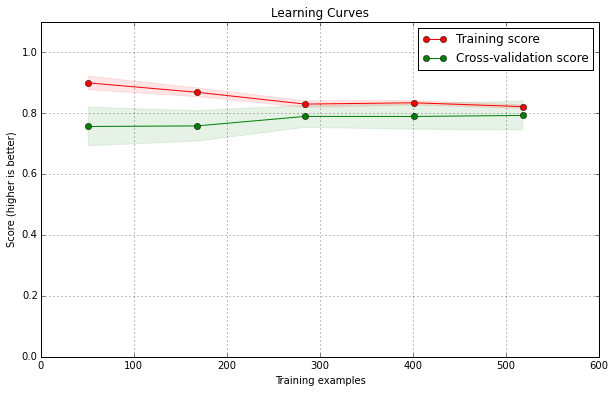

CPU times: user 468 ms, sys: 104 ms, total: 572 ms
Wall time: 5min 43s


In [8]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = 'Learning Curves', 
                    X           = X_train.values.astype(np.float32), 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StatifiedCV, 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [9]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train.values.astype(np.float32), 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = -1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 100 ms, sys: 40 ms, total: 140 ms
Wall time: 1min


[[400  38]
 [ 78  60]]


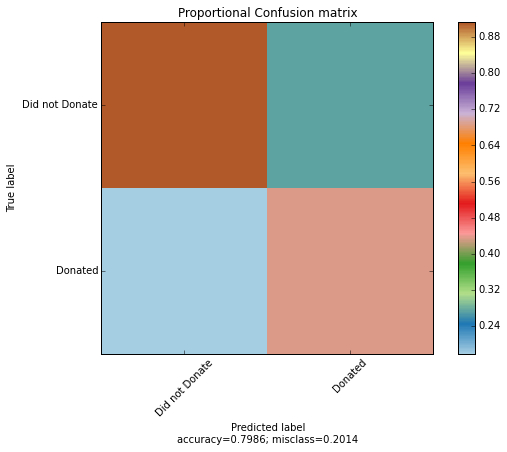

Accuracy 0.7986, mis-class rate 0.2014


In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

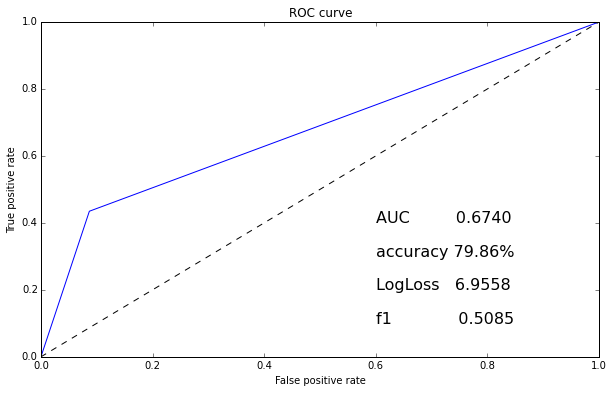

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

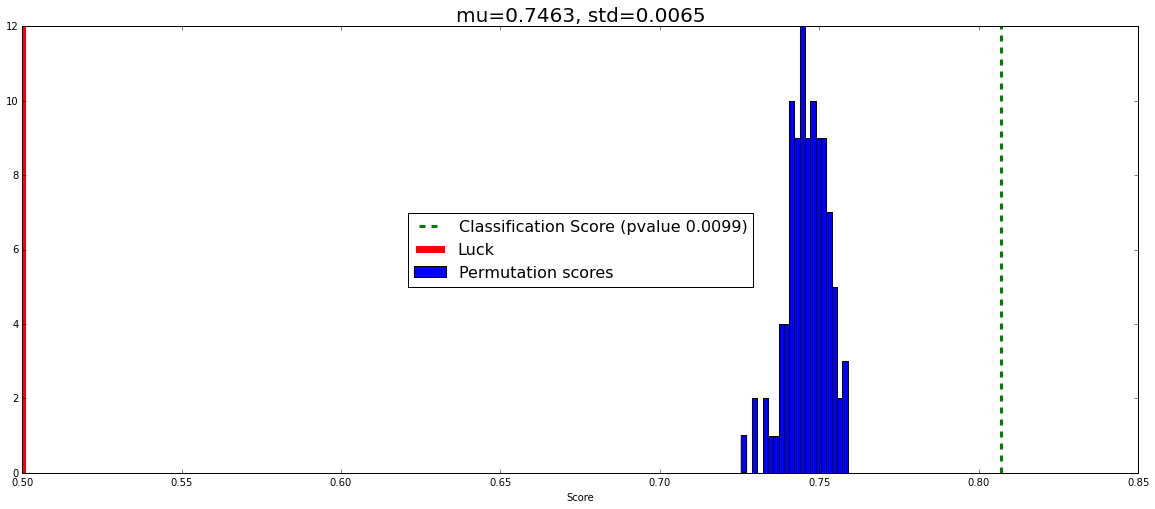

CPU times: user 3min 10s, sys: 1.33 s, total: 3min 12s
Wall time: 1h 23min 30s


In [12]:
%%time

# score : The true score without permuting targets.
# permutation_scores : array, shape (n_permutations,)
#                     The scores obtained for each permutation.
# pvalue : The returned value equals 
#              > p-value if scoring returns bigger numbers for better scores (e.g., accuracy_score). 
#              > If scoring is a loss function (i.e. when lower is better such as with mean_squared_error) 
#                then this is actually the complement of the p-value: 1 - p-value.

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = -1) 
# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)


plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')

ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.title('mu={:.4f}, std={:.4f}'.format(mu,std), fontsize=20)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

In [13]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

bagged_scikit_nn           ,        ,   0.7986 ,  6.9558 , 0.6740 , 0.5085 , 0.7463 , 0.0065


# Predict the leaderboard score with linear regression

In [14]:
# load the R extension
%load_ext rpy2.ipython

# see http://ipython.readthedocs.org/en/stable/config/extensions/index.html?highlight=rmagic
# see http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic

clear all but functions rm(list = setdiff(ls(), lsf.str()))
R functions in Dropbox:
 [1] "confusion.matrix_ROC.R" "eda.R"                  "knitr_settings.R"      
 [4] "lm_utilities.R"         "lsp.R"                  "matrix.power.R"        
 [7] "metrics.R"              "multiplot.R"            "my.special.functions.R"
[10] "NOT_IN.R"               "SDAFE.R"                "signOnToTwitter.R"     
[13] "source.dropbox.R"       "stem_plot.R"           
to load these functions: source("/home/george/Dropbox/R_functions/*.R")

To save graphical parameters: opar = par(no.readonly=TRUE)
to restore graphical parameters: par(opar)


In [15]:
# Import python variables into R
%R -i accuracy,logloss,AUC,f1,mu,std

In [16]:
%%R
# read in the scores.csv file and perform a linear regression with it using this process's variables

score_data = read.csv('../input/scores.csv')

lm.fit     = lm(leaderboard_score ~ accuracy + logloss + AUC + f1 + mu + std, 
                data      = score_data, 
                na.action = na.omit)

slm.fit = step(lm.fit, direction = "both", trace=0)

predicted_leaderboard_score = predict(object   = slm.fit, 
                                      newdata  = data.frame(accuracy,logloss,AUC,f1,mu,std),
                                      interval = "prediction", level = 0.99)

print(round(predicted_leaderboard_score,4))

     fit    lwr    upr
1 0.8084 0.0429 1.5738


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [33]:
#clf.set_params(**clf_params)
clf.fit(X_train.values.astype(np.float32), y_train)

BaggedScikitClassifier(base_estimator=Classifier(batch_size=10, debug=False, dropout_rate=None, f_stable=0.001,
      hidden=<sknn.nn.Layer `Rectifier`: name='hidden', units=100>,
      layers=[<sknn.nn.Layer `Rectifier`: name='hidden', units=100>, <sknn.nn.Layer `Softmax`: name='output'>],
      learning_momentum=0.9, le...e=97,
      regularize=None, valid_set=None, valid_size=None, verbose=True,
      weight_decay=None),
            n_estimators=15)

## Load the test data

In [34]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [35]:
y_pred = clf.predict(X_test.values.astype(np.float32)).ravel()
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test.values.astype(np.float32))
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[  5.32215059e-01   4.67784971e-01]
 [  8.90477240e-01   1.09522872e-01]
 [  8.65536153e-01   1.34463772e-01]
 [  8.86783600e-01   1.13216370e-01]
 [  4.22802091e-01   5.77197909e-01]
 [  1.89969927e-01   8.10029984e-01]
 [  7.37736285e-01   2.62263745e-01]
 [  9.58714843e-01   4.12850343e-02]
 [  9.99967933e-01   3.19885330e-05]
 [  9.84968185e-01   1.50317950e-02]]
[0.46778497, 0.10952287, 0.13446377, 0.11321637, 0.57719791, 0.81002998, 0.26226375, 0.041285034, 3.1988533e-05, 0.015031795]


# Create the submission file

In [37]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()